In [1]:
# --- Step 1: Setup and Installation ---
print("--- Installing necessary libraries ---")
!pip install pandas numpy pyarrow scikit-learn matplotlib seaborn tensorflow --quiet
print("--- Libraries installed successfully. ---")

import pandas as pd
import numpy as np
import os
import glob
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import joblib
import gc
import pyarrow.parquet as pq
from scipy.interpolate import CubicSpline

--- Installing necessary libraries ---
--- Libraries installed successfully. ---


2025-09-25 13:25:25.145408: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758806725.332798      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758806725.391339      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# --- Step 2: Define Kaggle Paths ---
print("\n--- Defining Paths ---")
PREVIOUS_RUN_INPUT_DIR = '/kaggle/input/bis-lstm-regressor'
DATASET_INPUT_DIR = '/kaggle/input/vitaldb-preprocessing/VitalDB_Preprocessing'
KAGGLE_WORKING_DIR = '/kaggle/working/'

FEATURE_DIR_PATH = os.path.join(DATASET_INPUT_DIR, 'featured_batches')
PREVIOUS_CHECKPOINT_PATH = os.path.join(PREVIOUS_RUN_INPUT_DIR, 'checkpoints', 'ckpt-04.keras')
SCALER_PATH = os.path.join(PREVIOUS_RUN_INPUT_DIR, 'final_LSTM_scaler.joblib')

NEW_CHECKPOINT_DIR = os.path.join(KAGGLE_WORKING_DIR, 'augmented_finetune_checkpoints')
os.makedirs(NEW_CHECKPOINT_DIR, exist_ok=True)
FINAL_MODEL_SAVE_PATH = os.path.join(KAGGLE_WORKING_DIR, 'final_AUGMENTED_LSTM_regressor.keras')
print(f"--- Features: {FEATURE_DIR_PATH} ---")
print(f"--- Model to fine-tune: {PREVIOUS_CHECKPOINT_PATH} ---")
print(f"--- New checkpoints will be saved to: {NEW_CHECKPOINT_DIR} ---")


--- Defining Paths ---
--- Features: /kaggle/input/vitaldb-preprocessing/VitalDB_Preprocessing/featured_batches ---
--- Model to fine-tune: /kaggle/input/bis-lstm-regressor/checkpoints/ckpt-04.keras ---
--- New checkpoints will be saved to: /kaggle/working/augmented_finetune_checkpoints ---


In [3]:
# --- Step 3: Reconnaissance and Patient Split ---
print("\n--- Performing reconnaissance and patient split... ---")
feature_files = sorted(glob.glob(os.path.join(FEATURE_DIR_PATH, '*.parquet')))
if not feature_files: raise FileNotFoundError(f"CRITICAL ERROR: No engineered feature files found.")
master_feature_set = set()
for file_path in feature_files:
    schema = pq.read_schema(file_path)
    master_feature_set.update(schema.names)
MASTER_FEATURES = sorted([f for f in master_feature_set if f not in ['patient_id', 'BIS/BIS']])
TARGET = 'BIS/BIS'
N_FEATURES = len(MASTER_FEATURES)
all_pids = pd.concat([pd.read_parquet(f, columns=['patient_id']) for f in feature_files])['patient_id'].unique()
train_pids, val_pids = train_test_split(all_pids, test_size=0.2, random_state=42)
train_pids_set = set(train_pids)
val_pids_set = set(val_pids)
print(f"Split into {len(train_pids_set)} training patients and {len(val_pids_set)} validation patients.")


--- Performing reconnaissance and patient split... ---
Split into 2589 training patients and 648 validation patients.


In [4]:
# --- Step 4: Load the Pre-fitted Scaler ---
print("\n--- Loading the pre-fitted scaler... ---")
scaler = joblib.load(SCALER_PATH)
print("Scaler loaded successfully.")


--- Loading the pre-fitted scaler... ---
Scaler loaded successfully.


In [5]:
# --- Step 5: The Data Augmentation Function ---
NOISE_LEVEL = 0.02
TIME_WARP_FACTOR = 0.05
AUGMENTATION_PROBABILITY = 0.8

def generate_random_curves(n_sequences, n_timesteps, n_knots=4):
    x = np.linspace(0, 1, n_knots)
    y = np.random.randn(n_sequences, n_knots)
    cs = CubicSpline(x, y, axis=1)
    return cs(np.linspace(0, 1, n_timesteps))

def augment_sequences(sequences):
    # 1. Jittering (Adding Noise)
    noise = np.random.normal(loc=0, scale=NOISE_LEVEL, size=sequences.shape)
    sequences = sequences + noise
    
    # 2. Time Warping
    n_sequences, n_timesteps, n_features = sequences.shape
    # Generate smooth random curves for warping
    time_warps = generate_random_curves(n_sequences, n_timesteps) * TIME_WARP_FACTOR
    # Create the warped time axis
    warped_time_axis = np.arange(n_timesteps) + time_warps
    
    warped_sequences = np.zeros_like(sequences)
    for i in range(n_sequences):
        for j in range(n_features):
            # Interpolate the original signal onto the warped time axis
            interp_func = np.interp(np.arange(n_timesteps), warped_time_axis[i], sequences[i, :, j])
            warped_sequences[i, :, j] = interp_func
            
    return warped_sequences

In [6]:
# --- Step 6: The Augmented Data Pipeline ---
SEQUENCE_LENGTH = 120
BATCH_SIZE = 1024
def data_generator(pids_set, files, is_training=True):
    while True:
        for file_path in files:
            df_chunk = pd.read_parquet(file_path)
            df_chunk = df_chunk[df_chunk['patient_id'].isin(pids_set)]
            if len(df_chunk) > SEQUENCE_LENGTH:
                df_chunk = df_chunk.reindex(columns=MASTER_FEATURES + [TARGET]).fillna(0)
                if 'BIS_per_PPF_rate' in df_chunk.columns:
                    df_chunk['BIS_per_PPF_rate'] = np.clip(df_chunk['BIS_per_PPF_rate'], -1000, 1000)
                feature_data = scaler.transform(df_chunk[MASTER_FEATURES])
                target_data = df_chunk[TARGET].values
                dataset = keras.utils.timeseries_dataset_from_array(
                    data=feature_data, targets=target_data[SEQUENCE_LENGTH:],
                    sequence_length=SEQUENCE_LENGTH, batch_size=BATCH_SIZE, shuffle=is_training
                )
                for X, y in dataset:
                    # --- APPLY AUGMENTATION ONLY TO TRAINING DATA ---
                    if is_training and np.random.rand() < AUGMENTATION_PROBABILITY:
                        X = augment_sequences(X.numpy())
                    yield X, y
        if not is_training: break
output_signature = (tf.TensorSpec(shape=(None, SEQUENCE_LENGTH, N_FEATURES), dtype=tf.float32), tf.TensorSpec(shape=(None,), dtype=tf.float32))
train_dataset = tf.data.Dataset.from_generator(lambda: data_generator(train_pids_set, feature_files), output_signature=output_signature).prefetch(tf.data.AUTOTUNE)
val_dataset = tf.data.Dataset.from_generator(lambda: data_generator(val_pids_set, feature_files, is_training=False), output_signature=output_signature).prefetch(tf.data.AUTOTUNE)
print("--- Augmented high-performance tf.data pipelines created. ---")

--- Augmented high-performance tf.data pipelines created. ---


I0000 00:00:1758806738.135596      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1758806738.136257      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [7]:
# --- Step 7: Load Model and Fine-Tune ---
print(f"\n--- Loading pre-trained model from: {PREVIOUS_CHECKPOINT_PATH} ---")
tf.keras.mixed_precision.set_global_policy('mixed_float16')
model = load_model(PREVIOUS_CHECKPOINT_PATH)
print("--- Re-compiling model with AdamW optimizer for augmented fine-tuning ---")
optimizer = tf.keras.optimizers.AdamW(learning_rate=1e-4, weight_decay=1e-5, clipnorm=1.0)
model.compile(optimizer=optimizer, loss='mae', metrics=['mae', 'mse'])
model.summary()

callbacks = [
    keras.callbacks.ReduceLROnPlateau(monitor='val_mae', factor=0.2, patience=2, min_lr=1e-6, verbose=1),
    keras.callbacks.EarlyStopping(monitor='val_mae', patience=5, restore_best_weights=True, mode='min'),
    keras.callbacks.ModelCheckpoint(FINAL_MODEL_SAVE_PATH, save_best_only=True, monitor='val_mae', mode='min')
]

print(f"\n--- Starting Augmented Fine-Tuning from the loaded checkpoint... ---")
steps_per_epoch = 34906
validation_steps = 8726
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=2,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=callbacks
)
print("--- Augmented fine-tuning complete. ---")


--- Loading pre-trained model from: /kaggle/input/bis-lstm-regressor/checkpoints/ckpt-04.keras ---
--- Re-compiling model with AdamW optimizer for augmented fine-tuning ---


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 120, 64)        │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 120, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 120, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,777 (124.13 KB)

 Trainable params: 31,585 (123.38 KB)

 Non-trainable params: 192 (768.00 B)


--- Starting Augmented Fine-Tuning from the loaded checkpoint... ---
Epoch 1/2


I0000 00:00:1758806747.144260      71 cuda_dnn.cc:529] Loaded cuDNN version 90300


34906/34906 ━━━━━━━━━━━━━━━━━━━━ 3976s 114ms/step - loss: 5.6157 - mae: 5.6157 - mse: 76.4999 - val_loss: 6.2075 - val_mae: 6.2075 - val_mse: 85.1617 - learning_rate: 1.0000e-04
Epoch 2/2
34906/34906 ━━━━━━━━━━━━━━━━━━━━ 4020s 115ms/step - loss: 5.3940 - mae: 5.3940 - mse: 70.1634 - val_loss: 6.2298 - val_mae: 6.2298 - val_mse: 86.1105 - learning_rate: 1.0000e-04
--- Augmented fine-tuning complete. ---



--- Evaluating Final Model on a Sample Patient ---
--- Visualizing timeline for Patient 1 ---
339/339 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step

--- FINAL REGRESSION REPORT (Augmented Fine-Tuning) ---
  Validation MAE on sample patient: 7.6222
  Validation R² on sample patient:  0.6403
--------------------------------------------------------


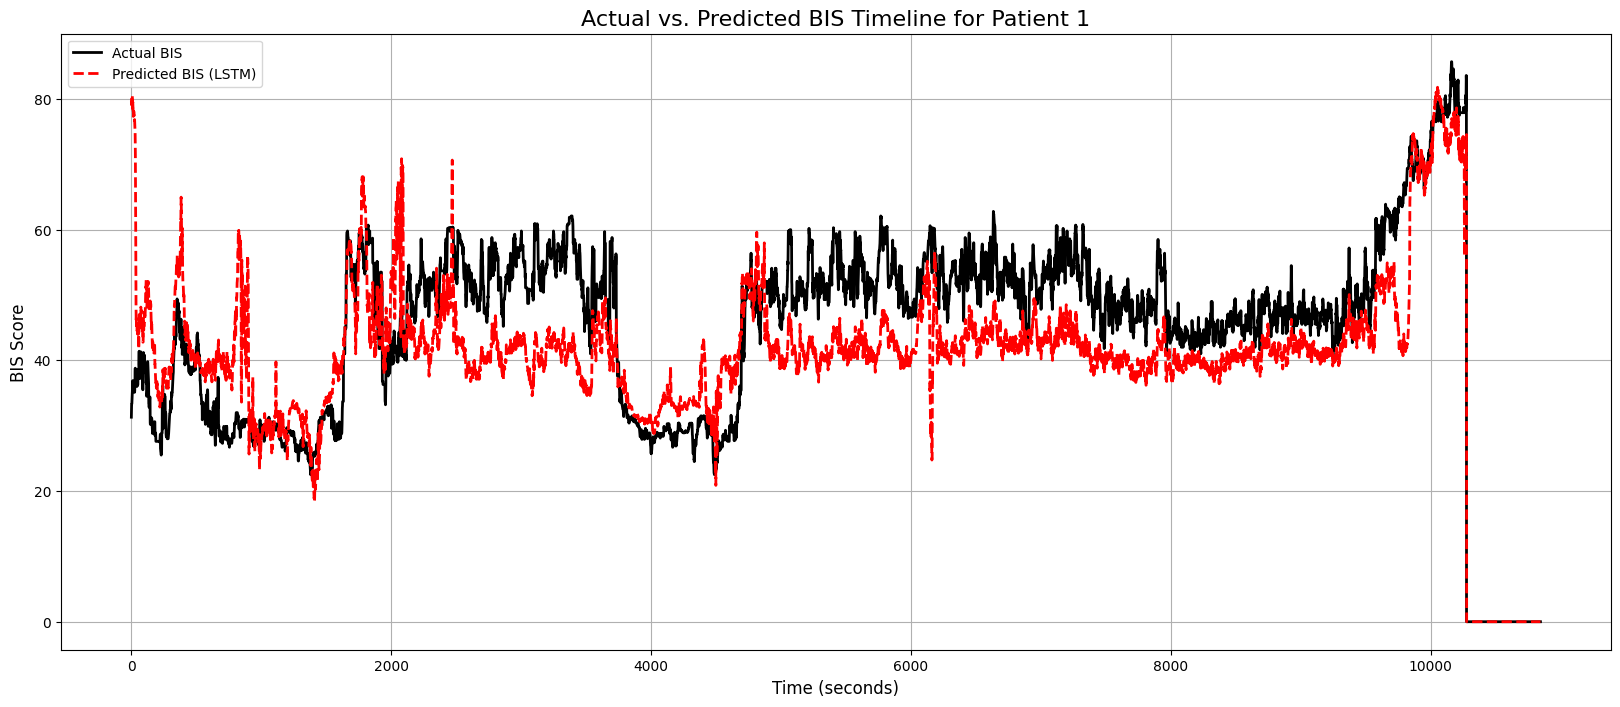

In [8]:
# --- Step 8: Final Evaluation ---
print("\n--- Evaluating Final Model on a Sample Patient ---")

# The EarlyStopping callback with restore_best_weights=True means the 'model' object
# in our notebook's memory is already holding the weights from the best epoch.
# We can use it directly for evaluation.
best_model = model

# Select a patient from the validation set for visualization
# This uses the 'val_pids_set' variable from the previous cells
patient_to_visualize_id = list(val_pids_set)[0]
print(f"--- Visualizing timeline for Patient {patient_to_visualize_id} ---")

# We need to load the data again to get the raw features for this one patient
df_list = [pd.read_parquet(f) for f in feature_files]
master_df = pd.concat(df_list)
patient_df = master_df[master_df['patient_id'] == patient_to_visualize_id].copy()

# Clean up memory immediately after we're done with the large dataframe
del master_df, df_list
gc.collect()

# --- Preprocess the single patient's data EXACTLY as we did in the pipeline ---
# This ensures the data fed to the model is in the correct format and scale.
patient_df = patient_df.reindex(columns=MASTER_FEATURES + [TARGET]).fillna(0)

# The final, paranoid data cleaning step
if 'BIS_per_PPF_rate' in patient_df.columns:
    patient_df['BIS_per_PPF_rate'] = np.clip(patient_df['BIS_per_PPF_rate'], -1000, 1000)

# Transform the features using our loaded scaler
patient_feature_data = scaler.transform(patient_df[MASTER_FEATURES])
patient_target_data = patient_df[TARGET].values

# --- Create sequences from the patient's data ---
patient_sequences = []
patient_targets = []
for i in range(len(patient_df) - SEQUENCE_LENGTH):
    patient_sequences.append(patient_feature_data[i:i+SEQUENCE_LENGTH])
    patient_targets.append(patient_target_data[i+SEQUENCE_LENGTH])

X_patient = np.array(patient_sequences)
y_true_patient = np.array(patient_targets)

# --- Run Prediction and Generate Report ---
# We add a check to make sure the patient had enough data to create sequences
if len(X_patient) > 0:
    y_pred_patient = best_model.predict(X_patient).flatten()

    print("\n--- FINAL REGRESSION REPORT (Augmented Fine-Tuning) ---")
    print(f"  Validation MAE on sample patient: {mean_absolute_error(y_true_patient, y_pred_patient):.4f}")
    print(f"  Validation R² on sample patient:  {r2_score(y_true_patient, y_pred_patient):.4f}")
    print("--------------------------------------------------------")

    # --- Generate the Final Visualization ---
    plt.figure(figsize=(20, 8))
    plt.plot(y_true_patient, label='Actual BIS', color='black', linewidth=2)
    plt.plot(y_pred_patient, label='Predicted BIS (LSTM)', color='red', linestyle='--', linewidth=2)
    plt.title(f'Actual vs. Predicted BIS Timeline for Patient {patient_to_visualize_id}', fontsize=16)
    plt.xlabel('Time (seconds)', fontsize=12)
    plt.ylabel('BIS Score', fontsize=12)
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print(f"Could not generate visualization: No valid sequences found for Patient {patient_to_visualize_id}.")